# Imports

In [82]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import MinMaxScaler

TESTING = True

# Classe que representa uma MLP

Implementado de uma maneira vetorizada por mini batch. 

In [14]:
class MLP():
    def __init__(self, dimensions=[], momentum=0.9, classification=True, 
                 lr=1, testing=False):
        self.lr = lr
        self.velocities = []
        self.momentum = momentum
        self.classification = classification
        
        # Initialize fully connected layers
        self.layers = []
        for idx, (input_dim, output_dim) in enumerate(dimensions, 1):
            self.layers.append(self.Linear(input_dim, output_dim))
            # For each linear layer, add a velocity term starting at 0
            self.velocities.append(np.zeros((input_dim, output_dim)))
            if idx != len(dimensions):
                self.layers.append(self.Sigmoid())
            else:
                self.layers.append(self.Softmax()) # for the last use softmax
            
        if classification:
            self.cost = self.CrossEntropy()
        else:
            pass
        
    class Sigmoid():
        def forward(self, x):
            self.old_y = np.exp(x) / (1. + np.exp(x))
            return self.old_y

        def backward(self, grad):
            return self.old_y * (1. - self.old_y) * grad

    class Softmax():
        def forward(self,x):
            self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
            return self.old_y

        def backward(self,grad):
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

    class CrossEntropy():
        def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

        def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)

    class Linear():
        def __init__(self,n_in,n_out):
            self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
            self.biases = np.zeros(n_out)

            self.w_vel = np.zeros((n_in,n_out))
            self.b_vel = np.zeros(n_out)

        def update_velocity(self, w_vel, b_vel):
            self.w_vel = w_vel
            self.b_vel = b_vel

        def forward(self, x):
            self.old_x = x
            return np.dot(x,self.weights) + self.biases

        def backward(self,grad):
            self.grad_b = grad.mean(axis=0)
            self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
            return np.dot(grad,self.weights.transpose())

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
            
    def fit(self, x, y, n_iter=100, mini_batch=32):
        for _ in range(n_iter):   
            for start_idx in range(0, len(x), mini_batch):
                x_batch = x[start_idx:start_idx+mini_batch]
                y_batch = y[start_idx:start_idx+mini_batch]   
                
                # Forward and backward
                self.loss(x_batch,y_batch)
                self.backward()
                
                # Update according to momentum
                for layer in self.layers:
                    if type(layer) == self.Linear:
                        new_w_vel = self.momentum*layer.w_vel + self.lr*layer.grad_w
                        new_b_vel = self.momentum*layer.b_vel + self.lr*layer.grad_b
                        
                        layer.weights -= new_w_vel
                        layer.weights -= new_b_vel
                        
                        layer.update_velocity(new_w_vel, new_b_vel)

    def predict(self, x):
        output = self.forward(x)
        if self.classification:
            return output.argmax(axis=-1)                       



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Funções auxiliares

Diversas funções que seram utilizadas para ambos os datasets

Função  para normalizar os dados que vamos utilizar posteriormente

In [19]:
def normalize_data(x_train, x_test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm, x_test_norm

Função para rodar 1 experimento

In [79]:
def run_experiment(x, y, test_percent, hidden_layers, cicles, lr, momentum,
                  classification=True):
    start_time = time.time()
    
    # Process our data and normalize
    y_dummies = pd.get_dummies(y)
    x_train, x_test, y_train, y_test = train_test_split(x, y_dummies, stratify=y, 
                                                       test_size=test_percent)
    x_train, x_test = normalize_data(x_train, x_test)

    # Create model
    dimensions = [(x.shape[1], 32)]
    if hidden_layers > 1:
        dimensions += [(32, 4), (4, y_dummies.shape[1])]
    else:
        dimensions += [(32, y_dummies.shape[1])]
    mlp = MLP(dimensions=dimensions, momentum=momentum, lr=lr, 
             classification=classification)
    
    # Train and evaluate
    mlp.fit(x_train, y_train.values, n_iter=cicles)
    preds = mlp.predict(x_test)
    acc = accuracy_score(y_test.values.argmax(axis=-1), preds)
    end_time = time.time()
    
    return acc, end_time-start_time
    

Roda todos os nossos experimentos

In [100]:
def run_various_experiments(x, y):
    # Default values
    cols = ["hidden_layers", "cicles", "momentum", "lr", "test_percent"]
    temp = [1, 1000, 0.9, 0.1, 0.3]
    default = {col:val for col, val in zip(cols, temp)}

    # Values to be tested
    temp = [ [1, 2], [1, 10, 100, 1000, 10000], [0.5, 0.7, 0.9, 0.95, 0.97, 0.99],
            [0.01, 0.1, 1, 10], [0.1, 0.3, 0.5]]
    test_values = {col:val for col, val in zip(cols, temp)}

    # Dictionary of results
    results_cols = ["Accuracy", "Time", "Value"]
    results = {col:pd.DataFrame(columns=results_cols) 
                   for col in cols}

    for name, values in test_values.items():
        params = {key:value for key, value in default.items() if key != name}
        if TESTING: # A global testing flag for quickly prototyping
            params["cicles"] = 1
        for value in values:
            params[name] = value
            acc, runtime = run_experiment(x, y, **params)
            results[name].loc[len(results[name])] = [acc, runtime, value]
            break
        break
    return results



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Classificação - winequality-red.csv 

In [15]:
TARGET = "category"
df = pd.read_csv("winequality-red.csv")
df.drop(columns=["Unnamed: 0"], inplace=True) # drop index
print("Categorias:", df[TARGET].unique())
df.head()

Categorias: ['Mid' 'Good' 'Bad']


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Mid
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Mid
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Mid
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Mid
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Mid


Verificar por nulos

In [37]:
print(f"Temos {df.isna().sum().sum()} nulos na nossa tabela")

Temos 0 nulos na nossa tabela


Vamos analisar a quantidade de dados por categoria

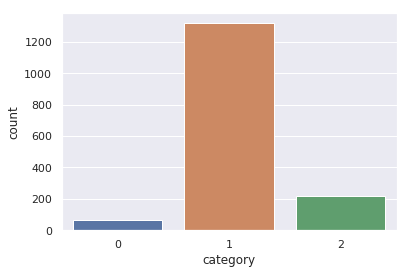

In [38]:
sns.countplot(df["category"])

Mapear os valores categóricos do nosso target para numéricos

In [17]:
df["category"] = df["category"].map({"Bad":0, "Mid":1, "Good":2})

In [18]:
x = df.drop(columns=[TARGET])
y = df[TARGET]

In [ ]:
#TARGET = "category"
df = pd.read_csv("")
#df.drop(columns=["Unnamed: 0"], inplace=True) # drop index
#print("Categorias:", df[TARGET].unique())
#df.head()